In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import load_npy
from record_0_main import smlt_ma
from record_3_rsvr import smlt_rsvr

from disp import set_plot

cc = np.concatenate

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

Load either Coen or WT Gold behavior data

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
CTR_OFFSET = 0

df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
ntr = np.max(df_behav.ID) + 1
df_trs = [df_behav[df_behav.ID == i] for i in range(ntr)]

tr_lens = np.array([len(df_tr) for df_tr in df_trs])
tr_lens_cum = cc([[0], np.cumsum(tr_lens)])

n_t_total = np.sum(tr_lens)
assert n_t_total == tr_lens_cum[-1]
df_behav = None

In [4]:
# MA params from baker fits
params_ma = load_npy('data/simple/neur/baker_ma.npy')
nnrn = len(params_ma['TAU_R'])

In [9]:
# reservoir ntwk
RADIUS = 1
TAU = np.median(params_ma['TAU_R'])
w_rec = np.random.randn(nnrn, nnrn)/np.sqrt(nnrn)
evs = np.linalg.eig(w_rec)[0]
w_rec *= (RADIUS/np.max(np.abs(evs)))

w_in = np.random.randn(nnrn, 2)/np.sqrt(2)

params_rsvr = {'w_rec': w_rec, 'w_in': w_in, 'tau': TAU}

......

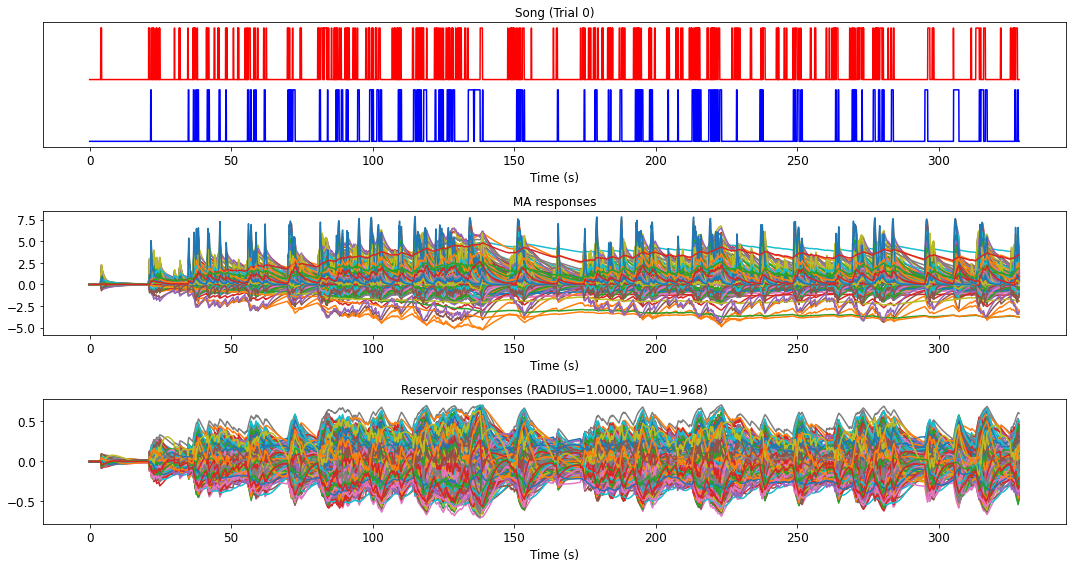

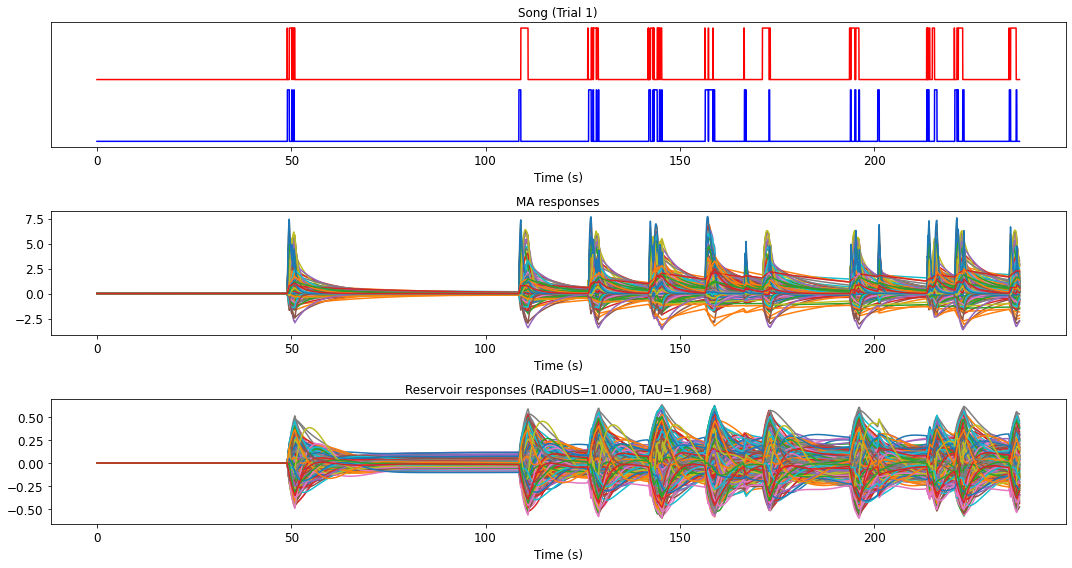

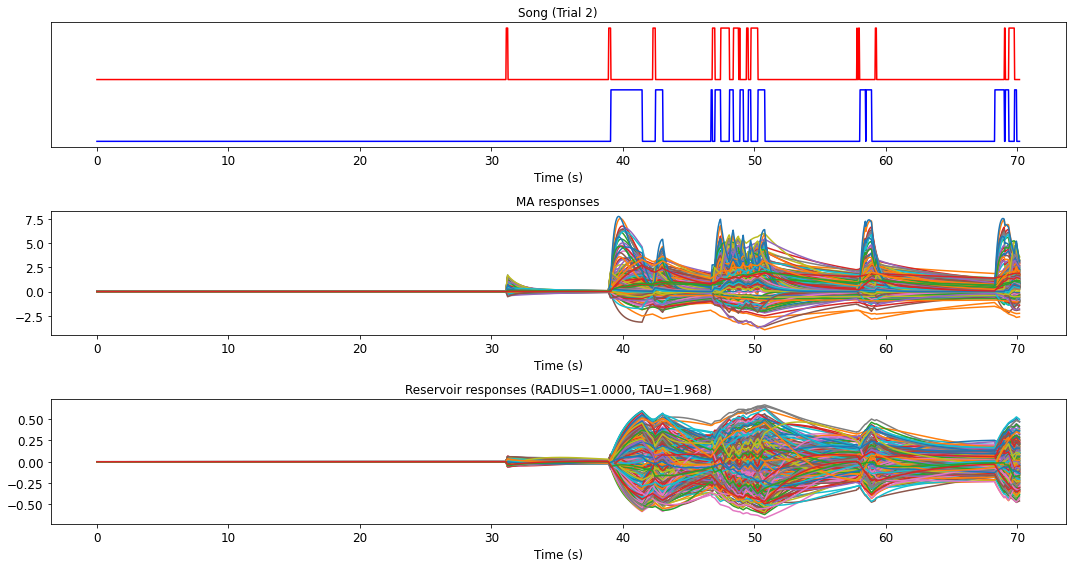

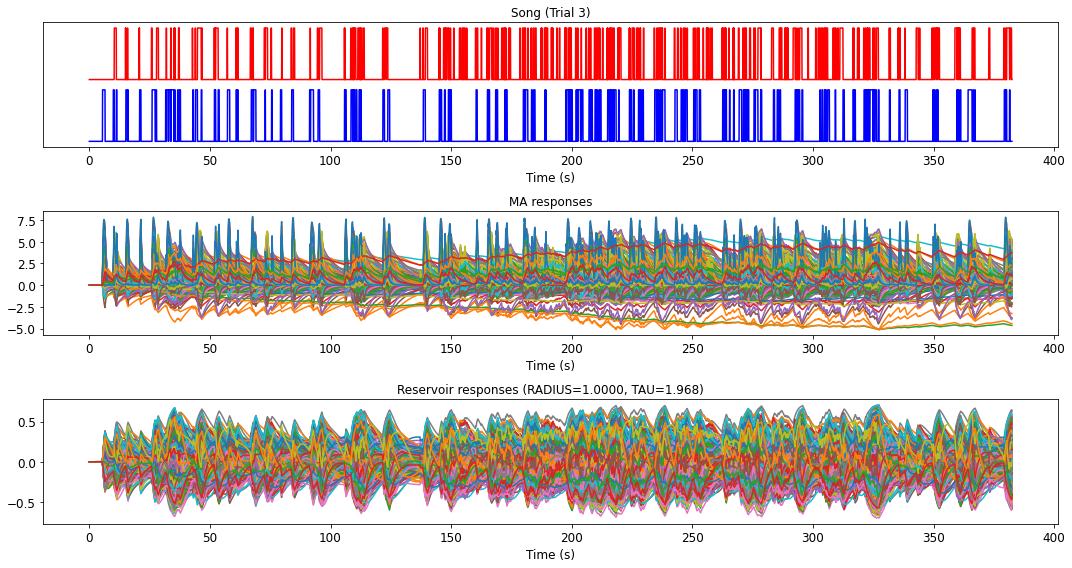

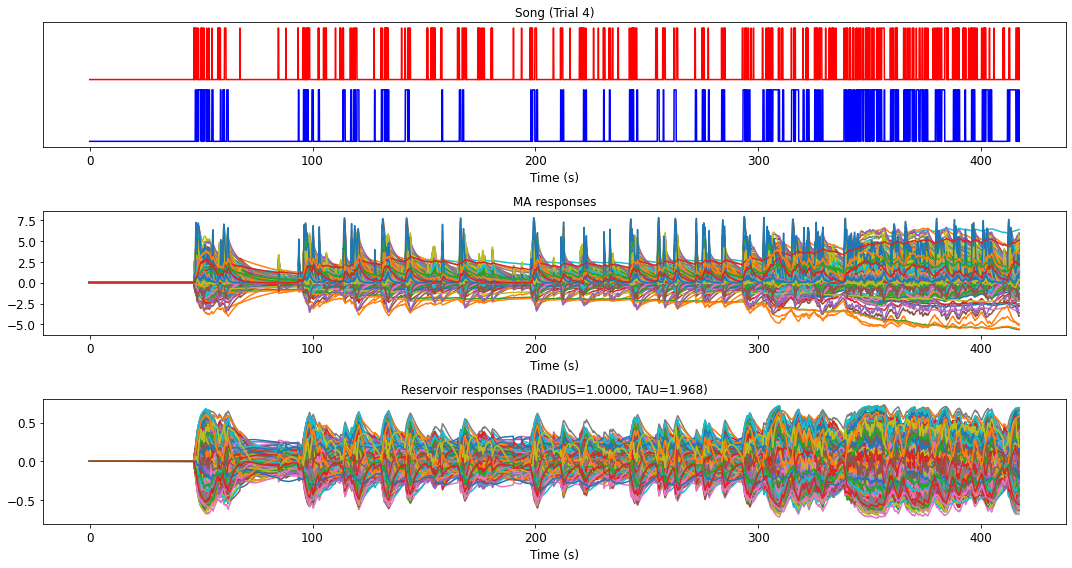

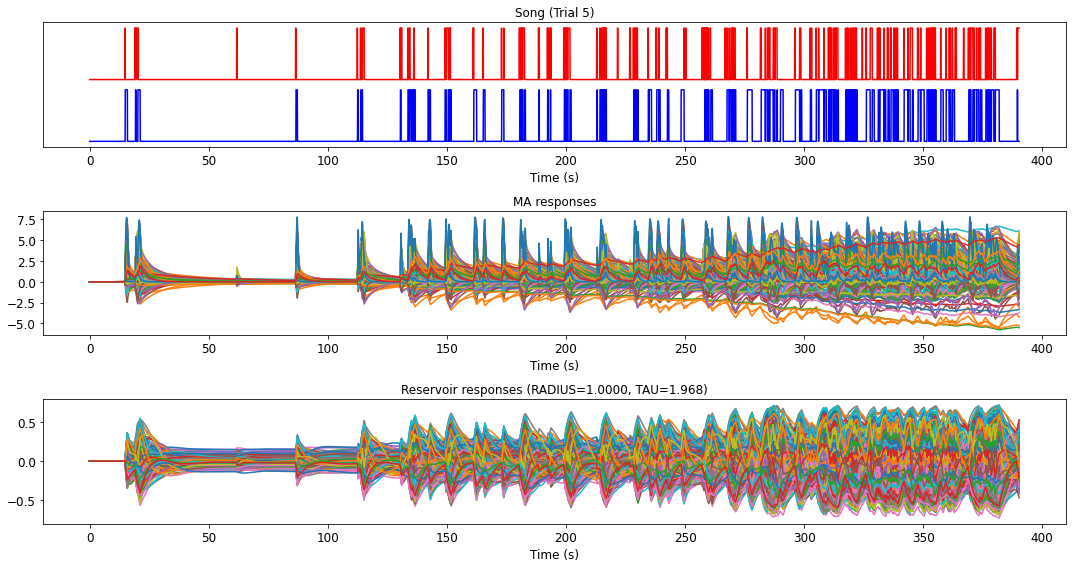

In [10]:
# compute surrogate neural responses for each trial
for ctr, df_tr in enumerate(df_trs[:6]):
    df_tr_nrl = df_tr.copy()
    sys.stdout.write('.')
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    # simulate population response
    rs_ma = smlt_ma(i_s, i_p, params_ma, DT)
    rs_rsvr = smlt_rsvr(i_s, i_p, params_rsvr, DT)
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 8), tight_layout=True)
    t = np.arange(len(i_s))*DT
    
    axs[0].plot(t, i_s, c='b')
    axs[0].plot(t, i_p+1.2, c='r')
    axs[0].yaxis.set_visible(False)
    set_plot(axs[0], title=f'Song (Trial {ctr})')
    
    axs[1].plot(t, rs_ma)
    set_plot(axs[1], title='MA responses')
    
    axs[2].plot(t, rs_rsvr)
    set_plot(axs[2], title=f'Reservoir responses (RADIUS={RADIUS:.4f}, TAU={TAU:.3f})')
    
    for ax in axs:
        set_plot(ax, x_label='Time (s)')